In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from statsmodels.api import OLS
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [79]:
communities_and_crime = fetch_ucirepo(id=183) 

X = communities_and_crime.data.features 
Y = communities_and_crime.data.targets 

In [80]:
#处理数据。这些地区数据对回归来说很难利用。不过分类可以自己决定。
X = X.drop(columns=["state", "county", "community", "communityname", "fold"])
X = X.replace('?',np.nan)

label_encoder = LabelEncoder()
categorical_columns = X.select_dtypes(include=['object']).columns
for i in categorical_columns:
    X[i] = label_encoder.fit_transform(X[i])

In [112]:
#数据归一
#y不能中心化，不然prop变成负的就离谱了
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

colnames =X.columns

X_train, X_test, Y_train, Y_test = train_test_split(
    X_standardized, 
    Y, 
    test_size=0.2,      
    shuffle=True       
)

In [ ]:
#以下是features筛选

In [94]:
# OLS, 筛选标准是对x变量做t test，P-value小于0.05的视为sigificant
model_OLS = OLS(Y_train,X_train).fit()
model_OLS.summary()
OLS_features = X.columns[model_OLS.pvalues < 0.05]
print(OLS_features)

Index(['MedOwnCostPctIncNoMtg', 'LemasSwFTFieldPerPop'], dtype='object')


In [95]:
#stepwise,forward. 筛选标准是aic
def calculate_aic(estimator, X, y):
    n, k = X.shape  
    y_pred = estimator.predict(X)
    residual_sum_of_squares = ((y - y_pred) ** 2).sum(axis=0).item()
    aic = n * np.log(residual_sum_of_squares / n) + 2 * k
    return -aic 

def aic_scorer_wrapper(estimator, X, y):
    estimator.fit(X, y)
    return calculate_aic(estimator, X, y)
    
ln = LinearRegression()

sfs_forward = SFS(
    ln,
    k_features='best',
    forward=True,
    floating=False,
    scoring=aic_scorer_wrapper,  
    cv=None
)

sfs_forward.fit(X_train,Y_train)

print("Selected features:", list(sfs_forward.k_feature_names_))

Selected features: ['racepctblack', 'racePctWhite', 'racePctHisp', 'agePct12t29', 'agePct16t24', 'numbUrban', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWRetire', 'perCapInc', 'whitePerCap', 'blackPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy', 'MalePctDivorce', 'MalePctNevMarr', 'TotalPctDiv', 'PctKids2Par', 'PctWorkMom', 'PctIlleg', 'NumImmig', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PersPerOccupHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 'OwnOccLowQuart', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctSameCity85', 'LemasTotalReq', 'PolicReqPerOffic', 'RacialMatchCommPol', 'LandArea', 'PctUsePubTrans']


In [96]:
##stepwise,backward. 筛选标准是aic
sfs_backward = SFS(
    ln,
    k_features='best',
    forward=False,
    floating=False,
    scoring=aic_scorer_wrapper,  
    cv=None
)

sfs_backward.fit(X_train, Y_train)

print("Selected features:", list(sfs_backward.k_feature_names_))

Selected features: ['racepctblack', 'racePctHisp', 'agePct12t29', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWRetire', 'medFamInc', 'whitePerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'TotalPctDiv', 'PctKids2Par', 'PctWorkMom', 'PctIlleg', 'NumImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PersPerOccupHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 'RentLowQ', 'MedRent', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'LemasSwornFT', 'PolicReqPerOffic', 'PolicPerPop', 'PctUsePubTrans', 'PolicOperBudg', 'PolicBudgPerPop']


In [97]:
#用 LASSO + CV 进行特征选择时，筛选标准是保留 L1 后系数非零的特征。
#L1 惩罚的稀疏性特性，让他在correlated group中倾向于只保留一个特征（偶尔不止一个）。
#不过保留哪个系数不稳定。并且它的筛选标准也不是基于特征的重要性。严格意义上不算筛选数据的手段，不过考虑到数据中存在correlate的数据。使用lasso是合理的
#CV是用来选择lamba的，避免惩罚太严重
y_train = Y_train.values.ravel()
lasso_cv = LassoCV(fit_intercept=False,max_iter=5000)
lasso_cv.fit(X_train, y_train)

index_lasso_cv = 0
features_cv = list()
features_value_cv = list()
for i in lasso_cv.coef_:
    if i != 0:
        features_cv.append(index_lasso_cv)
        features_value_cv.append(i)
    index_lasso_cv = index_lasso_cv +1
print(colnames[features_cv])
print(features_value_cv)

Index(['racepctblack', 'racePctWhite', 'agePct12t29', 'pctUrban',
       'MalePctDivorce', 'PctKids2Par', 'PctWorkMom', 'PctIlleg',
       'PctPersDenseHous', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded',
       'MedRentPctHousInc', 'NumStreet', 'RacialMatchCommPol',
       'LemasPctOfficDrugUn'],
      dtype='object')
[np.float64(0.0016291585413652698), np.float64(-0.040681950106201355), np.float64(-0.0020394791106577844), np.float64(0.004801525385120443), np.float64(0.022366003591872106), np.float64(-0.057968805968693686), np.float64(-0.005589790194785526), np.float64(0.054688631654512085), np.float64(0.013453076278125553), np.float64(0.015194755555537473), np.float64(-0.008112260297751906), np.float64(0.0015255959160118413), np.float64(0.0015417198555340362), np.float64(0.009446311966487738), np.float64(-0.006510153691352198), np.float64(0.00030091085367959803)]


In [100]:
#ElasticNet+CV，筛选标准是保留 L1 + L2后系数非零的特征。
#和LASSO相比的优点可以在一定程度上避免被L1删除掉可能重要的特征
elasticNet_cv = ElasticNetCV(fit_intercept=False,max_iter=5000)
elasticNet_cv.fit(X_train, y_train)

index_elasticNet_cv = 0
features_cv_ela = list()
features_value_cv_ela = list()

for i in elasticNet_cv.coef_:
    if i != 0:
        features_cv_ela.append(index_elasticNet_cv)
        features_value_cv_ela.append(i)
    index_elasticNet_cv += 1  
    
print(X_train.columns[features_cv_ela])
print(features_value_cv_ela)

Index(['racepctblack', 'racePctWhite', 'agePct12t29', 'pctUrban',
       'MalePctDivorce', 'PctKids2Par', 'PctWorkMom', 'PctIlleg',
       'PctPersDenseHous', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded',
       'MedRentPctHousInc', 'NumStreet', 'RacialMatchCommPol',
       'LemasPctOfficDrugUn'],
      dtype='object')
[np.float64(0.005281055100051366), np.float64(-0.03788312247566186), np.float64(-0.0017333329203767858), np.float64(0.0046983198351290695), np.float64(0.023019044464071596), np.float64(-0.05619325883430374), np.float64(-0.005690529115644623), np.float64(0.05343978510662408), np.float64(0.015195272098312269), np.float64(0.015152984095709672), np.float64(-0.007968928526211281), np.float64(0.0019456991296511333), np.float64(0.0020050143019430533), np.float64(0.00945404917261665), np.float64(-0.006477491745054532), np.float64(0.0005245348591919556)]


In [ ]:
#选择哪一个方法找出来的数据？
#稳定性验证 + 内部交叉验证
#进行internal split。把train set分成两组。第一组选择特征，第二组验证MSE。运行10次，查看MSE分布。（）
#解释一下我为什么linear regression我用了两个方法。因为我sm的OLS用习惯了，然后意识到OLS好像默认不给incertercept，想起来后换成了sklearn的

In [104]:
#全部封装进函数。我自己都记不清，我给变量取了那些名字了。
def feature_choose(n_repeats, X, Y):
    mse_results = {"Least Squares": [], "Lasso": [], "Elastic Net": [], "Forward Stepwise": [], "Backward Stepwise": []}
    y = np.ravel(Y)
    ln = LinearRegression()
    
    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
        
        X_train_const = sm.add_constant(X_train)
        model_OLS = sm.OLS(y_train, X_train_const).fit()
        selected = model_OLS.pvalues[model_OLS.pvalues < 0.05].index
        selected = selected.drop('const', errors='ignore') 
        
        X_train_OLS = X_train[selected]
        X_test_OLS = X_test[selected]
        
        ln.fit(X_train_OLS, y_train)
        y_pred_OLS = ln.predict(X_test_OLS)
        mse_results["Least Squares"].append(mean_squared_error(y_test, y_pred_OLS))
        
        # Forward Stepwise
        sfs_forward = SFS(ln, 
                          k_features='best',
                          forward=True,
                          floating=False,
                          scoring=aic_scorer_wrapper, 
                          cv=None)
        sfs_forward.fit(X_train, y_train)
        forward_features = list(sfs_forward.k_feature_names_)
        
        X_train_forward = X_train[forward_features]
        X_test_forward = X_test[forward_features]
        
        ln.fit(X_train_forward, y_train)
        y_pred_forward = ln.predict(X_test_forward)
        mse_results["Forward Stepwise"].append(mean_squared_error(y_test, y_pred_forward))
        
        # Backward Stepwise
        sfs_backward = SFS(ln,
                           k_features='best',
                           forward=False,
                           floating=False,
                           scoring=aic_scorer_wrapper,
                           cv=None)
        sfs_backward.fit(X_train, y_train)
        backward_features = list(sfs_backward.k_feature_names_)
        
        X_train_backward = X_train[backward_features]
        X_test_backward = X_test[backward_features]
        
        ln.fit(X_train_backward, y_train)
        y_pred_backward = ln.predict(X_test_backward)
        mse_results["Backward Stepwise"].append(mean_squared_error(y_test, y_pred_backward))
        
        # Lasso
        lasso = LassoCV(alphas=np.logspace(-3, 3, 10), cv=5, max_iter=5000)
        lasso.fit(X_train, y_train)
        mse_results["Lasso"].append(mean_squared_error(y_test, lasso.predict(X_test)))
        
        # Elastic Net
        elastic_net = ElasticNetCV(alphas=np.logspace(-3, 3, 10), l1_ratio=np.linspace(0.1, 0.9, 5), cv=5, max_iter=5000)
        elastic_net.fit(X_train, y_train)
        mse_results["Elastic Net"].append(mean_squared_error(y_test, elastic_net.predict(X_test)))
    
    return mse_results

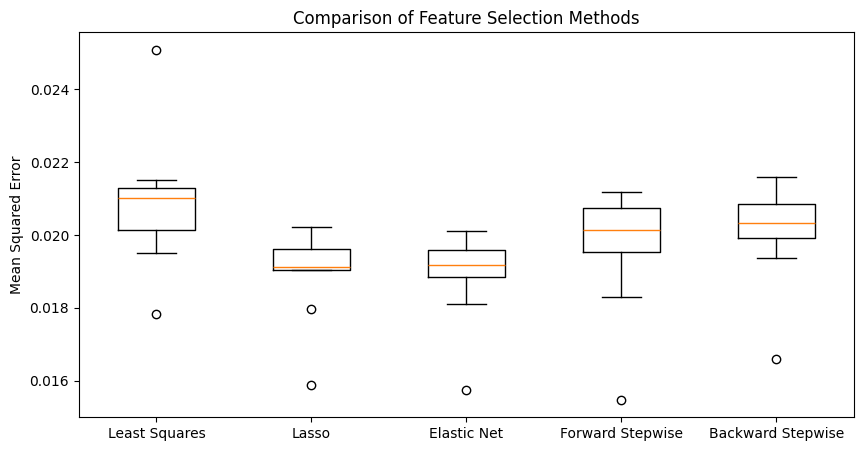

In [105]:
mse_results = feature_choose(n_repeats=10, X=X_train, Y=Y_train)

plt.figure(figsize=(10, 5))
plt.boxplot(mse_results.values(),tick_labels=mse_results.keys())
plt.ylabel("Mean Squared Error")
plt.title("Comparison of Feature Selection Methods")
plt.show()

In [118]:
#从图片可以看出elasticNet选择的数据最好，那么之后会用它选择的数据来建模
selected_columns = X_train.columns[features_cv_ela]  
X_selected = X_train[selected_columns]  
X_test = X_test[selected_columns]  

In [132]:
#写一个自动衡量模型参数的def
def model_score(X, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    n = X.shape[0]
    p = X.shape[1]
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

        
    
    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Adjusted R2": r2_adj
    }

In [133]:
#Lasso
lasso = LassoCV(alphas=np.logspace(-3, 3, 10), cv=5, max_iter=5000)
lasso.fit(X_selected, y_train)
model_score(X_selected,Y_test,lasso.predict(X_test))

{'MSE': 0.04581051600920617,
 'RMSE': np.float64(0.21403391322219517),
 'MAE': 0.1696477388660933,
 'R2': -0.021910507400626278,
 'Adjusted R2': -0.032272084155005265}

In [128]:
#Ridge
ridge = RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5)
ridge.fit(X_selected, y_train)
model_score(X_selected,Y_test,ridge.predict(X_test))

{'MSE': 0.04505618521855756,
 'RMSE': np.float64(0.21226442287523728),
 'MAE': 0.1678228903137054}

In [135]:
#ElasticNet
elastic_net = ElasticNetCV(alphas=np.logspace(-3, 3, 10), l1_ratio=np.linspace(0.1, 0.9, 5), cv=5, max_iter=5000)
elastic_net.fit(X_selected, y_train)
model_score(X_selected,Y_test,elastic_net.predict(X_test))

{'MSE': 0.046226645810713264,
 'RMSE': np.float64(0.21500382743270702),
 'MAE': 0.17037196698909612,
 'R2': -0.031193254107019674,
 'Adjusted R2': -0.041648952501007086}